# Sample use of TensorViz

This notebook shows some example of how to use TensorViz to render into tensors.

First, import `tenviz`. And other modules if need:

In [1]:
import tenviz

import torch
import numpy as np

The `tenviz.Context` manages the drawing data and rendering commands. Scripts may have multiple contexts. 

In [2]:
context = tenviz.Context()

The `tenviz.io` package can load or write some popular formats:

In [3]:
geo = tenviz.io.read_3dobject("../samples/data/mesh/teapot.off")

The `tenviz.io.read_3dobject` function returns a `tenviz.geometry.Geometry` instance with the attributes: `verts`, `normals`, `colors` and `faces`. They are PyTorch tensors on the CPU. The `verts` and `normals` are  `torch.float`, `colors` is `torch.uint8`, and `faces` is `torch.int32`. Only `verts` is guaranteed to be non `None`.

The module `tenviz.geometry` has the `compute_normals` method for calculating vertex normal by triangle normals averaging:

In [4]:
import tenviz.geometry
geo.normals = tenviz.geometry.compute_normals(geo.verts, geo.faces)

## Drawing a mesh and rendering to a tensor

The first goal is to render the previously loaded mesh with the following vertex and fragment shaders:

In [5]:
!cat ../samples/shaders/simple.vert

#version 420

in vec4 position;
uniform mat4 ProjModelview;

void main() {
  gl_Position = ProjModelview * position;
}

In [6]:
!cat ../samples/shaders/simple.frag

#version 420

out vec4 frag_color;

uniform vec4 color;

void main() {
	 frag_color = color;
}

TensorViz allows to easily bind shaders attributes, uniforms or samplers:

In [7]:
with context.current():
    # Create a DrawProgram. It's a central class to TensorViz. All drawing operations
    # are made using it.
    program = tenviz.DrawProgram(tenviz.DrawMode.Triangles,
                                 vert_shader_file="../samples/shaders/simple.vert",
                                 frag_shader_file="../samples/shaders/simple.frag")

    # Sets the vertex attribute
    # using the geo.verts tensor
    program["position"] = geo.verts

    # TensorViz has place holders for view matrices from the viewer or passed by the user.
    program["ProjModelview"] = tenviz.MatPlaceholder.ProjectionModelview

    # Uniforms can also be set
    program["color"] = torch.tensor(
        [0.8, 0.2, 0.2, 1.0], dtype=torch.float)
    program.indices.from_tensor(geo.faces)

* Most operations are necessary to be under a context. The `context.current` returns a Python's context manager for declaring that all operations bellow the `with` statement belongs to the given context.


## Rendering to tensors

This is a common operation for projects using shaders for general computing and 3D vision. 

First, create a framebuffer on the target context: 

In [8]:
with context.current():
    framebuffer = tenviz.create_framebuffer({0: tenviz.FramebufferTarget.RGBUint8})

In shaders, a framebuffer can be associated with multiple targets. Each integer key from the input dict corresponds to one of the `layout(location = <key>)` on the GLSL shader. The first fragment shader file doesn't contain that, in that case then the default target is `0`. The dict value specifies the target type, the standard RGB byte frame bufer is asked (`tenviz.FramebufferTarget.RGBUint8`).

The next lines will set up the projection and modelview matrices.

In [9]:
proj_matrix = tenviz.Projection.perspective(45, 1, 10, aspect=1).to_matrix()

center = geo.verts.mean(0)
view_matrix = np.array([[1, 0, 0, -center[0]],
                        [0, 1, 0, -center[1]],
                        [0, 0, 1, -3],
                        [0, 0, 0, 1]])


Finally rendering is done calling the `render` method, passing the matrices, framebuffer and scene:

In [10]:
context.render(proj_matrix, view_matrix, framebuffer, [program])

The specified targets during framebuffer constructor will generate a key that returns its target's texture object:

In [11]:
fb_texture = framebuffer[0]
print(fb_texture)

To convert textures to tensor, use the `to_tensor` method. Note that the context must be current:

In [12]:
with context.current():
    fb_tensor = fb_texture.to_tensor()

The object then can be used as any other tensor:

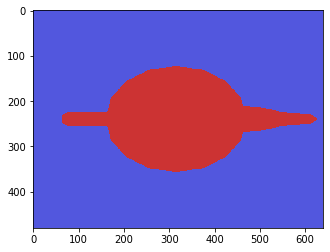

In [13]:
import matplotlib.pyplot as plt
plt.imshow(fb_tensor.cpu().numpy())
plt.show()

## Multiple rendering targets

As stated previously, framebuffer may have many targets. For example, the following fragment shader specify them explicitly:

In [14]:
!cat ../samples/shaders/multiple_out.frag

#version 420

layout(location = 0) out vec4 out_rgba8;
layout(location = 1) out vec4 out_rgba32f;
layout(location = 2) out vec4 out_rgba32i;
layout(location = 3) out int out_ri;

void main() {
  out_rgba8 = vec4(255, 0, 0, 1);
  out_rgba32f = vec4(0, 1.0, 0.0, 1);
  out_rgba32i = vec4(0, 0, 2000, 1);
  out_ri = 100;
}


Create a new program for the `multiple_out` shaders: 

In [15]:
with context.current():
    program = tenviz.DrawProgram(tenviz.DrawMode.Triangles,
                                 vert_shader_file="../samples/shaders/multiple_out.vert",
                                 frag_shader_file="../samples/shaders/multiple_out.frag")

    program["position"] = geo.verts

    program["ProjModelview"] = tenviz.MatPlaceholder.ProjectionModelview

    program.indices.from_tensor(geo.faces)

Now the framebuffer's creation dict should reflect the fragment's `layout(location = <key>)`  section. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


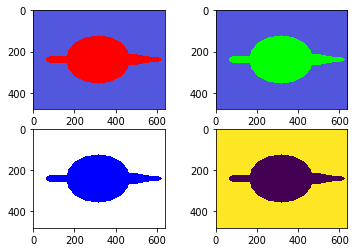

In [16]:
with context.current():
    framebuffer = tenviz.create_framebuffer({
        0: tenviz.FramebufferTarget.RGBUint8,
        1: tenviz.FramebufferTarget.RGBAFloat,
        2: tenviz.FramebufferTarget.RGBInt32,
        3: tenviz.FramebufferTarget.RInt32
    })    
    
context.render(proj_matrix, view_matrix, framebuffer, [program])

# Retrieve each framebuffer target textures.
with context.current():
    rgbu8 = framebuffer[0].to_tensor().cpu().numpy()
    rgbaf = framebuffer[1].to_tensor().cpu().numpy()
    rgbai32 = framebuffer[2].to_tensor(non_blocking=False).clone().cpu().numpy()
    ri32 = framebuffer[3].to_tensor().cpu().numpy()

plt.subplot(2, 2, 1)
plt.imshow(rgbu8)

plt.subplot(2, 2, 2)
plt.imshow(rgbaf)

plt.subplot(2, 2, 3)
plt.imshow(rgbai32)

plt.subplot(2, 2, 4)
plt.imshow(ri32.squeeze())

plt.show()

## Loading textures

Textures are created from tensors with the `tenviz.tex_from_tensor` function:

In [17]:
import PIL
image = torch.from_numpy(np.array(PIL.Image.open("../samples/data/images/tex1.png")))
with context.current():
    texture = tenviz.tex_from_tensor(image)

In [18]:
print(texture)

k2D Texture of width 256, height 256 of type Uint8 


## Use the same buffers on multiple programs

Native API buffers can be created and distributed to programs. Use the `tenviz.buffer_from_tensor` method: 

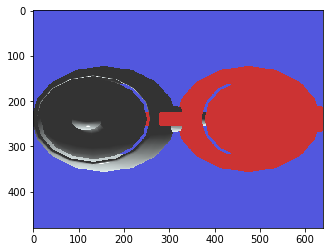

In [19]:
with context.current():
    verts = tenviz.buffer_from_tensor(geo.verts)
    normals = tenviz.buffer_from_tensor(geo.normals)
    indices = tenviz.buffer_from_tensor(geo.faces, target=tenviz.BufferTarget.Element,
                                       usage=tenviz.BufferUsage.Static)
    
    program1 = tenviz.DrawProgram(tenviz.DrawMode.Triangles,
                                  vert_shader_file="../samples/shaders/phong.vert",
                                  frag_shader_file="../samples/shaders/phong.frag")
    # Vertex parameters
    program1["in_position"] = verts
    program1["in_normal"] = normals
    
    # program["in_texcoord"] = geo.texcoords
    program1["Lightpos"] = torch.tensor([0, 4, 0, 1], dtype=torch.float)
    program1["Modelview"] = tenviz.MatPlaceholder.Modelview
    program1["NormalModelview"] = tenviz.MatPlaceholder.NormalModelview
    program1["ProjModelview"] = tenviz.MatPlaceholder.ProjectionModelview

    # Fragment shader parameters
    program1["AmbientColor"] = torch.tensor([0.2, 0.2, 0.2, 1], dtype=torch.float)
    program1["DiffuseColor"] = torch.tensor([0.75, 0.8, 0.8, 1], dtype=torch.float)
    program1["SpecularColor"] = torch.tensor([1, 1, 1, 1], dtype=torch.float)
    program1["SpecularExp"] = float(127)
    
    program1["Tex"] = texture
    program1.indices = indices
    
    program2 = tenviz.DrawProgram(tenviz.DrawMode.Triangles,
                                  vert_shader_file="../samples/shaders/simple.vert",
                                  frag_shader_file="../samples/shaders/simple.frag")
    # Vertex parameters
    program2["position"] = verts
    # program2["normals"] = normals
    program2["ProjModelview"] = tenviz.MatPlaceholder.ProjectionModelview
    program2["color"] = torch.tensor(
        [0.8, 0.2, 0.2, 1.0], dtype=torch.float)
    program2.indices = indices
    
    program1.transform = np.array([[1, 0, 0, -.5],
                                   [0, 1, 0, 0],
                                   [0, 0, 1, 0],
                                   [0, 0, 0, 1]])
    program2.transform = np.array([[1, 0, 0, .5],
                                   [0, 1, 0, 0],
                                   [0, 0, 1, 0],
                                   [0, 0, 0, 1]])
    
    context.render(proj_matrix, view_matrix, framebuffer, [program1, program2])
    
    fb_tensor = framebuffer[0].to_tensor().cpu().numpy()
    plt.imshow(fb_tensor)

## Mapping buffers as tensor

Another feature of TensorViz is mapping graphics buffers as GPU tensors without copying:

cuda:0


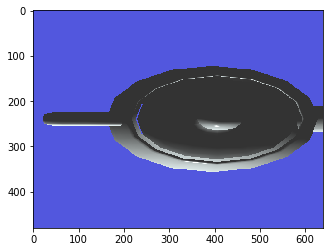

In [20]:
with context.current():
    with verts.as_tensor() as th_verts:
        print(th_verts.device)
        th_verts[:, 0] *= 1.5
        
program1.transform = np.eye(4, dtype=np.float32)

context.render(proj_matrix, view_matrix, framebuffer, [program1])
with context.current():    
    plt.imshow(framebuffer[0].to_tensor().cpu().numpy())
    
plt.show()